# Topic Models 1 - Comparison of Topic Models

This notebook explores a number of topic modelling algorithms within Gensim and compares them using the coherence measure.

* Section 1 - Import libraries and dataset
* Section 2 - Data cleaning and pre-processing
* Section 3 - Set up Gensim Model
* Section 4 - Comparison of Models - LSI, LDA and NMF
* Section 5 - Running the Gensim LDA model
* Section 6 - Running and evaluating Scikit learn NMF models

Dataset need to run notebook:

* noun_phrase_exploded.csv

Data saved to:

* topicmodelsaccom.csv
* topicmodelsfood.csv
* topicmodelsattract.csv


# Section 1: Import Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.util import ngrams
import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel,Phrases
from gensim.corpora import Dictionary
from gensim.models.nmf import Nmf as GensimNmf
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
import pyLDAvis.sklearn
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter
import ast
import pickle
import warnings
import re
warnings.filterwarnings("ignore")
import os
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\imoge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\imoge\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [29]:
# Bring in data from the aspect extraction - keywords notebook
df = pd.read_csv("noun_phrase_exploded.csv")
df.drop(columns = ["Unnamed: 0"],axis = 1,inplace = True)
df.drop(columns = ["len"],axis = 1,inplace = True)
df.head(2)

,OrigInd,Category,Town,Rating,all_text,sentences,cleaned_sentences,noun_phrases
0,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...","Nice break, shame about the accommodation... W...",nice break shame accommodation booked night st...,shame accommodation
1,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...","Nice break, shame about the accommodation... W...",nice break shame accommodation booked night st...,night stay december post-christmas


In [30]:
df.columns

Index(['OrigInd', 'Category', 'Town', 'Rating', 'all_text', 'sentences',
       'cleaned_sentences', 'noun_phrases'],
      dtype='object')

In [31]:
df[["OrigInd","cleaned_sentences","noun_phrases"]].head(10)

,OrigInd,cleaned_sentences,noun_phrases
0,0,nice break shame accommodation booked night st...,shame accommodation
1,0,nice break shame accommodation booked night st...,night stay december post-christmas
2,0,nice break shame accommodation booked night st...,family adult kid
3,0,would never not really sure expect review eith...,good terrible
4,0,would never not really sure expect review eith...,usual choice
5,0,first impression not good we arrived parked ca...,car park
6,0,first impression not good we arrived parked ca...,apartment furthest distance
7,0,bearing mind people apartment obviously self-c...,mind people apartment
8,0,bearing mind people apartment obviously self-c...,ton stuff haul room
9,0,bearing mind people apartment obviously self-c...,available nearer part resort


# Section 2: Data Cleaning and Pre-processing

In [32]:
# Get parts of speech, noun phrases and nouns
df['pos'] = df["noun_phrases"].apply(lambda x:nltk.tag.pos_tag(x.split()))
df['nouns'] = df['pos'].apply(lambda x: [i[0] for i in x if i[1].startswith('N')])

In [33]:
tokens = nltk.word_tokenize("hot delicious")
nltk.pos_tag(tokens)

[('hot', 'JJ'), ('delicious', 'JJ')]

In [34]:
# Look at examples - nouns are effectively fine-grained aspects
df[["cleaned_sentences","noun_phrases","nouns"]].head()

,cleaned_sentences,noun_phrases,nouns
0,nice break shame accommodation booked night st...,shame accommodation,"[shame, accommodation]"
1,nice break shame accommodation booked night st...,night stay december post-christmas,"[night, post-christmas]"
2,nice break shame accommodation booked night st...,family adult kid,"[family, adult, kid]"
3,would never not really sure expect review eith...,good terrible,[terrible]
4,would never not really sure expect review eith...,usual choice,[choice]


In [36]:
# Check to find how many rows have empty lists
result = df[df.astype(str)['nouns'] == '[]']
result.shape

(1225, 10)

In [37]:
# Have a look at what words are causing the problems - basically implicit aspects
result[["all_text","cleaned_sentences","noun_phrases","pos","nouns"]].sample(10)

,all_text,cleaned_sentences,noun_phrases,pos,nouns
8570,We need a Butlins abroad! We need a Butlins ab...,thing need improve queue centre stage red queu...,funny british,"[(funny, JJ), (british, JJ)]",[]
875,BUTLINS HALLOWEEN AND FIREWORKS 3 Day break We...,halloween firework break stayed ocean hotel la...,ready 1.,"[(ready, JJ), (1., CD)]",[]
41230,Lovely lunch! My friend and I visited for lun...,love food staff always seem friendly polite,friendly polite,"[(friendly, RB), (polite, JJ)]",[]
27121,Fabulous Sunday Roast We have just returned fr...,great experience lovely atmosphere really warm...,lovely atmosphere,"[(lovely, RB), (atmosphere, JJ)]",[]
36233,Menu to suit all Had a lovely meal at 47 Muss...,menu suit lovely meal mussel row last night fo...,friendly polite,"[(friendly, RB), (polite, JJ)]",[]
50281,Delicious food and a warm friendly welcome. We...,visited saturday lunchtime february lovely riv...,saturday lunchtime february,"[(saturday, JJ), (lunchtime, VBD), (february, ...",[]
48417,Dog friendly and warm Really appreciated a dog...,would not minded semi skimmed milk option hot ...,hot overall,"[(hot, JJ), (overall, JJ)]",[]
64528,Lovely drink Stopped here for a drink mid afte...,lovely drink stopped drink mid afternoon,lovely drink,"[(lovely, RB), (drink, VB)]",[]
71544,Buffet for a wake We cannot speak highly enoug...,liaised abbie helpful speedy getting back u,abbie helpful,"[(abbie, RB), (helpful, JJ)]",[]
45150,Fantastic! We had a fantastic dinner at The Ch...,one best meal experience long lovely setting,long lovely setting,"[(long, RB), (lovely, RB), (setting, VBG)]",[]


In [38]:
# Analyse
result["test"] = result["noun_phrases"].apply(lambda x: x.split())
result["combined"] = result["test"].apply(lambda x: ngrams(x,2))
result["word_count"] = result["combined"].apply(Counter)
result_df = pd.DataFrame(result["word_count"].sum().most_common(),columns = ["Word","Count"])

In [39]:
result_df.sort_values(by = "Count",ascending = False).head(10)

,Word,Count
0,"(friendly, helpful)",262
1,"(lovely, atmosphere)",61
2,"(friendly, attentive)",54
3,"(nice, atmosphere)",45
4,"(lovely, evening)",42
5,"(friendly, polite)",25
6,"(friendly, atmosphere)",24
7,"(lovely, touch)",20
8,"(lovely, setting)",17
9,"(lovely, cafe)",14


The most common words appear to be combinations of two adjectives 'friendly helpful', or instances where a word is not correctly recognised as a noun 'lovely evening' or 'lovely setting'. The term 'friendly helpful' is clearly talking about staff but this word is not present in the noun-phrase, possibly because it is caught up within the previous noun-phrase for this sentence in the overall review. These are in effect implicit aspects.

The cases where the second word is not recognised as a noun could be corrected fairly easily. However, the phrases comprised of two adjectives or a verb and adjective or verb and verb are more tricky.

Decision made to drop these items from the data

In [40]:
# Drop empty lists
df2 = df[df.astype(str)['nouns'] != '[]']
df2.drop(columns = ["pos"],axis = 1,inplace = True)
df2.shape

(79073, 9)

In [41]:
# Split into categories
dfaccom = df2[df2["Category"]=="Accommodation"]
dffood = df2[df2["Category"]=="Food"]
dfattract = df2[df2["Category"] =="Attractions"]
print(dfaccom.shape,dffood.shape,dfattract.shape)

(26664, 9) (44047, 9) (8362, 9)


In [42]:
# Extract a sample to test the topic models
def samp(df):
    s = np.random.rand(len(df)) < 0.8
    df_train = df[s]
    df_test = df[~s]
    return df_train,df_test

In [43]:
# Run function
train_test_accom = samp(dfaccom)
train_test_food = samp(dffood)
train_test_attract = samp(dfattract)

In [44]:
# Extract training and test sets
df_accom = train_test_accom[0]
df_food = train_test_food[0]
df_attract = train_test_attract[0]

df_accom_test = train_test_accom[1]
df_food_test = train_test_food[1]
df_attract_test = train_test_attract[1]

In [45]:
# Extract nouns from training and test sets
accom_nouns = df_accom["nouns"]
food_nouns = df_food["nouns"]
attract_nouns = df_attract["nouns"]

accom_nouns_test = df_accom_test["nouns"]
food_nouns_test = df_food_test["nouns"]
attract_nouns_test = df_attract_test["nouns"]

In [46]:
attract_nouns.head(10)

71828            [garden, winter]
71829              [garden, walk]
71830             [garden, visit]
71831                    [autumn]
71832            [plenty, flower]
71833    [ground, wonder, behold]
71834                    [garden]
71835                [experience]
71836              [latte, taste]
71837                     [water]
Name: nouns, dtype: object

In [15]:
# Implode dataframe back to sentence level from noun phrase level
#df_comb = df.groupby(["OrigInd","Category","Town","Rating","all_text","sentences","cleaned_sentences"]).agg({'noun_phrases':lambda x: " ".join(x)}).rename({'noun_phrases':'sentence'},axis = 1).reset_index()
#df_comb.drop(columns = ["sentence"],axis = 1,inplace = True)

# Section 3: Create BOW and Dictionaries for Gensim Topic Model

Note: Gensim is used as it is easier to compare models using coherence and much quicker to run on larger datasets with limited compute resources

In [47]:
# Functions to extract bigrams
def make_bigrams(texts):
    bigram = gensim.models.Phrases(texts,min_count = 1,threshold = 1)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in texts]

In [48]:
# Run function for training set
accom_nouns_bigrams = make_bigrams(accom_nouns)
food_nouns_bigrams = make_bigrams(food_nouns)
attract_nouns_bigrams = make_bigrams(attract_nouns)

# Run function for test set
accom_test_bigrams = make_bigrams(accom_nouns_test)
food_test_bigrams = make_bigrams(food_nouns_test)
attract_test_bigrams = make_bigrams(attract_nouns_test)

In [49]:
# Print first ten items of bigrams
print(food_nouns_bigrams[20:30])

[['setting'], ['dinner', 'eaten'], ['fruit', 'watery', 'base'], ['porridge', 'oat'], ['couple_table'], ['group'], ['plate', 'rest'], ['member_group'], ['lunch_date', 'friend'], ['setting']]


In [50]:
# Function to create dictionary and bow corpus for each category, filtering words that occur in more than 98% 
# documents and less than 2 documents, keep n = None to keep all the tokens in the dictionary as the dataset is pruned to just nouns anyway.

def run_topic(df):
    dictionary = gensim.corpora.Dictionary(df)
    dictionary.filter_extremes(no_below = 0.98, no_above = 2, keep_n = None)
    bow_corpus = [dictionary.doc2bow(doc) for doc in df]
    return dictionary,bow_corpus


In [51]:
# Create dictionaries and corpi for unigrams
accom_dict, accom_bow = run_topic(accom_nouns)
food_dict, food_bow = run_topic(food_nouns)
attract_dict, attract_bow = run_topic(attract_nouns)

In [52]:
print(len(accom_dict),len(food_dict),len(attract_dict))

4353 5317 2565


In [53]:
# Create dictionaries and corpi for bigrams
accom_dict_big, accom_bow_big = run_topic(accom_nouns_bigrams)
food_dict_big, food_bow_big = run_topic(food_nouns_bigrams)
attract_dict_big, attract_bow_big = run_topic(attract_nouns_bigrams)

In [54]:
# Look at an example item with word and frequencies
print([[(food_dict[id], freq) for id, freq in cp] for cp in food_bow[:10]])

[[('staff', 1)], [('frites', 1), ('pie', 1), ('steak', 1)], [('curry', 1), ('problem', 1)], [('lunch', 1)], [('food', 1), ('quality', 1), ('review', 1)], [('bit', 1), ('competent', 1), ('mash', 1), ('menu', 1)], [('food', 1), ('quality', 1)], [('lack', 1), ('specialisation', 1)], [('staff', 1), ('attentive', 1)], [('problem', 1), ('review', 1)]]


# Section 4: Comparing Gensim Bigram Models with 15 topics

### Latent Semantic Indexing

In [66]:
# Set random number of topics as a starting point to compare the gensim models
num_topics = 5

In [67]:
# Function to run LSI Model
def lsi(corpus, num_topics,dictionary):
    lsi_model = LsiModel(corpus = corpus,num_topics = num_topics, id2word = dictionary, chunksize = 500)
    return lsi_model

In [68]:
# run function for each category
lsi_accom = lsi(accom_bow_big, num_topics, accom_dict_big)
lsi_food = lsi(food_bow_big, num_topics, food_dict_big)
lsi_attract = lsi(attract_bow_big, num_topics, attract_dict_big)

In [69]:
# Show topics as a list - uncomment to show
lsi_accom_topics = lsi_accom.show_topics(formatted = False)
lsi_food_topics = lsi_food.show_topics(formatted = False)
lsi_attract_topics = lsi_attract.show_topics(formatted = False)

### Latent Dirchlet Allocation

In [70]:
# Define model
def lda(corpus, dictionary, num_topics):
    lda_model = LdaModel(corpus = corpus, num_topics=num_topics, id2word=dictionary,random_state = 42)
    return lda_model

In [71]:
# Run models for each category
lda_accom = lda(accom_bow_big, accom_dict_big,num_topics)
lda_food = lda(food_bow_big, food_dict_big,num_topics)
lda_attract = lda(attract_bow_big, attract_dict_big,num_topics)

In [72]:
# Show topics - uncomment to run
lda_accom_topics = lda_accom.show_topics(formatted = False)
lda_food_topics = lda_food.show_topics(formatted = False)
lda_attract_topics = lda_attract.show_topics(formatted = False)

### Non-negative Matrix Factorisation

In [73]:
# Function to run NMF Model
def nmf(corpus, dictionary,num_topics):
    nmf_model = GensimNmf(corpus = corpus, id2word = dictionary,num_topics = num_topics)
    return nmf_model

In [74]:
# run function for each category
nmf_accom = nmf(accom_bow_big, accom_dict_big,num_topics)
nmf_food = nmf(food_bow_big, food_dict_big,num_topics)
nmf_attract = nmf(attract_bow_big, attract_dict_big,num_topics)

In [75]:
# Show topics - uncomment to run
nmf_accom_topics = nmf_accom.show_topics(formatted = False)
nmf_food_topics = nmf_food.show_topics(formatted = False)
nmf_attract_topics = nmf_attract.show_topics(formatted = False)

### Comparison of models with random 5 topics for all models and categories

In [76]:
# Function to get coherence for each model on the top ten topic words using a standard 5 topics
def evaluate(model,model_topics,text,dictionary):
    model_topics = model.show_topics(formatted = False)
    model_topics = [[word for word, prob in topic] for topicid,topic in model_topics]
    model_coherence = CoherenceModel(topics = model_topics[:10],texts = text, dictionary = dictionary,window_size = 10).get_coherence()
    return model_coherence

In [77]:
# Run function for LSI
lsi_accom_eval = evaluate(lsi_accom,lsi_accom_topics,accom_nouns_bigrams,accom_dict_big)
lsi_food_eval = evaluate(lsi_food,lsi_food_topics,food_nouns_bigrams,food_dict_big)
lsi_attract_eval = evaluate(lsi_attract,lsi_attract_topics,attract_nouns_bigrams, attract_dict_big)

In [78]:
# Run function for LDA
lda_accom_eval = evaluate(lda_accom,lda_accom_topics,accom_nouns_bigrams,accom_dict_big)
lda_food_eval = evaluate(lda_food,lda_food_topics,food_nouns_bigrams,food_dict_big)
lda_attract_eval = evaluate(lda_attract,lda_attract_topics,attract_nouns_bigrams,attract_dict_big)

In [79]:
# Run function for NMF
nmf_accom_eval = evaluate(nmf_accom,nmf_accom_topics,accom_nouns_bigrams,accom_dict_big)
nmf_food_eval = evaluate(nmf_food, nmf_food_topics,food_nouns_bigrams,food_dict_big)
nmf_attract_eval = evaluate(nmf_attract,nmf_attract_topics,attract_nouns_bigrams,attract_dict_big)

In [80]:
# Function to graph results
def graph(coherences,indices,name):
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    fig, ax = plt.subplots()
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_facecolor("White")
    ax.bar(x,coherences,width = 0.5,tick_label=indices,align = 'center',color = "lightsteelblue",ec = "grey")
    ax.set_title("Topic Models Average Coherence Comparison: " + name,fontsize = 10,pad = 15)
    ax.set_xlabel('Models',labelpad = 10)
    ax.set_ylabel('Coherence Value',labelpad = 10)

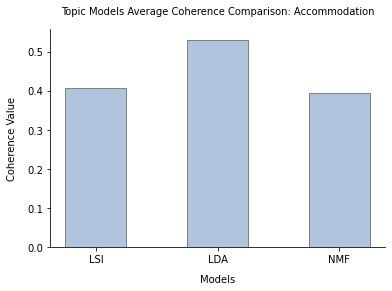

In [81]:
# Run function for accommodation
graph([lsi_accom_eval,lda_accom_eval, nmf_accom_eval],['LSI','LDA','NMF'],"Accommodation")

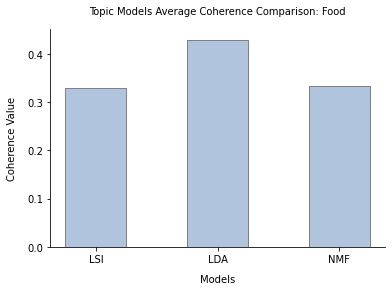

In [82]:
# Run function for food
graph([lsi_food_eval,lda_food_eval, nmf_food_eval],['LSI','LDA','NMF'],"Food")

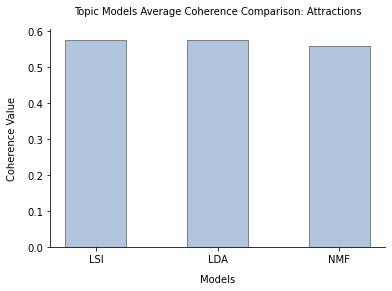

In [83]:
# Run function for attractions
graph([lda_attract_eval,lda_attract_eval, nmf_attract_eval],['LSI','LDA','NMF'],"Attractions")

Comment - LDA appears to offer the highest coherence for each category

# Section 5: Gensim LDA and NMF Models

## Get optimum number of topics

In [84]:
# Function to collect topic coherence and respective weights over a range of topic numbers

def results(model,dictionary, corpus, texts):
    
    # Get coherence values
    cv = []
    tm_list = []
    for num_topics in range(2,50+1,2):
        tm = model(corpus = corpus, num_topics = num_topics, id2word = dictionary)
        tm_list.append(tm)
        cm = CoherenceModel(model = tm, texts = texts, dictionary = dictionary, coherence = 'c_v')
        cv.append(cm.get_coherence())
        
    return cv

In [85]:
# Graph results
def graph_results(cv,name,num):
    
    x = range(2,50+1,2)
    fig, ax = plt.subplots()
    ax.set_facecolor("White")
    ax.plot(x,cv)
    ax.set_xlabel("Number of Topics")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.axvline(num,color = "grey",linestyle = "--",linewidth = 1)
    ax.set_ylabel("Coherence Score")
    ax.legend(("c_v"), loc = 'best',bbox_to_anchor=(1.0,1.0),frameon = False)
    ax.set_title("Coherence Values By Number of Topics:" + name,fontsize = 11)
    plt.show()

#### Accommodation

In [87]:
# run function for accommodation reviews
cv_lda = results(LdaModel,accom_dict_big,accom_bow_big,accom_nouns_bigrams)
cv_nmf = results(GensimNmf,accom_dict_big,accom_bow_big,accom_nouns_bigrams)

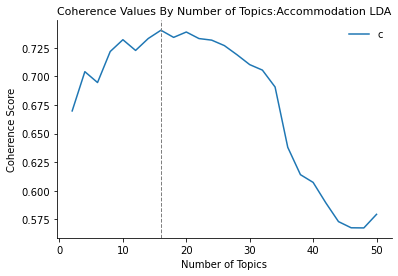

In [88]:
graph_results(cv_lda,"Accommodation LDA",16)

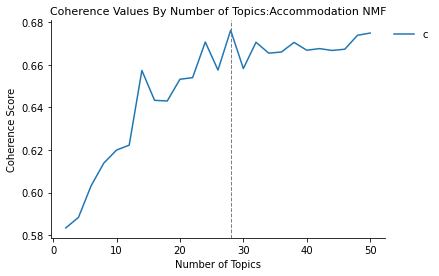

In [96]:
graph_results(cv_nmf,"Accommodation NMF",28)

#### Food

In [90]:
# run function for food reviews
cv_lda2 = results(LdaModel,food_dict_big,food_bow_big,food_nouns_bigrams)
cv_nmf2 = results(GensimNmf, food_dict_big,food_bow_big,food_nouns_bigrams)

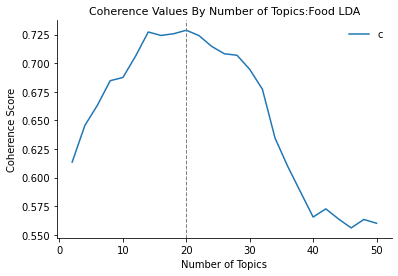

In [185]:
graph_results(cv_lda2,"Food LDA",20)

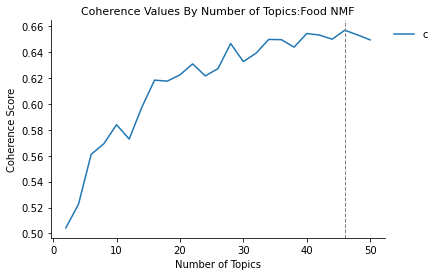

In [100]:
graph_results(cv_nmf2,"Food NMF",46)

#### Attractions

In [93]:
cv_lda3 = results(LdaModel,attract_dict_big,attract_bow_big,attract_nouns_bigrams)
cv_nmf3 = results(GensimNmf,attract_dict_big,attract_bow_big,attract_nouns_bigrams)

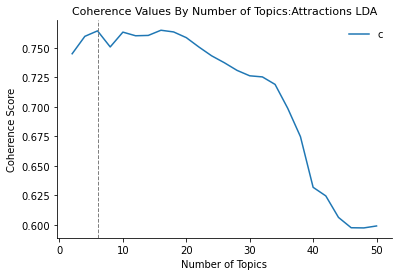

In [107]:
graph_results(cv_lda3,"Attractions LDA",6)

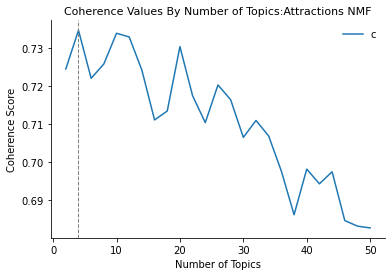

In [110]:
graph_results(cv_nmf3,"Attractions NMF",4)

## Implement Gensim LDA Model

In [112]:
# Function to run gensim lda
def lda_mod(corpus,n,dict):
    lda_model = LdaModel(corpus = corpus, num_topics=n, id2word=dict, passes=20)
    topics = lda_model.print_topics(num_words = 5)
    return topics,lda_model

In [114]:
# Run function using the highest topic coherence from the section above
lda_accom = lda_mod(accom_bow_big,16,accom_dict_big)
lda_food = lda_mod(food_bow_big,20,food_dict_big)
lda_attract = lda_mod(attract_bow_big,6,attract_dict_big)

In [115]:
# Print top 5 words for each topic in each category
lda_accom[0]

[(0,
  '0.111*"family" + 0.067*"house" + 0.055*"u" + 0.052*"town" + 0.049*"time"'),
 (1,
  '0.183*"area" + 0.074*"thing" + 0.066*"entertainment" + 0.040*"bath" + 0.037*"sea_view"'),
 (2,
  '0.112*"stay" + 0.075*"quality" + 0.075*"tidy" + 0.049*"trip" + 0.047*"year"'),
 (3,
  '0.192*"night" + 0.077*"experience" + 0.059*"shower" + 0.047*"floor" + 0.040*"side"'),
 (4,
  '0.151*"service" + 0.082*"child" + 0.069*"need" + 0.058*"morning" + 0.055*"choice"'),
 (5,
  '0.068*"plenty" + 0.055*"size" + 0.039*"husband" + 0.038*"manager" + 0.036*"group"'),
 (6,
  '0.136*"bed" + 0.048*"value" + 0.047*"park" + 0.043*"day" + 0.040*"bedroom"'),
 (7,
  '0.257*"breakfast" + 0.143*"place" + 0.049*"water" + 0.043*"door" + 0.038*"night_stay"'),
 (8,
  '0.149*"pool" + 0.050*"hour" + 0.050*"toilet" + 0.045*"access" + 0.029*"resort"'),
 (9,
  '0.139*"pub" + 0.123*"restaurant" + 0.060*"lunch" + 0.048*"dinner" + 0.040*"week"'),
 (10,
  '0.208*"food" + 0.103*"weekend" + 0.044*"accommodation" + 0.044*"friend" + 0.0

In [116]:
lda_food[0]

[(0,
  '0.190*"value" + 0.112*"course" + 0.077*"review" + 0.049*"food_good" + 0.047*"home"'),
 (1,
  '0.156*"experience" + 0.094*"cafe" + 0.075*"customer" + 0.064*"dish" + 0.062*"time"'),
 (2,
  '0.101*"value_money" + 0.076*"chicken" + 0.062*"quality_food" + 0.062*"tea" + 0.051*"shame"'),
 (3,
  '0.091*"location" + 0.058*"return" + 0.047*"money" + 0.047*"management" + 0.042*"cream"'),
 (4,
  '0.330*"meal" + 0.118*"quality" + 0.080*"table" + 0.050*"chef" + 0.048*"way"'),
 (5,
  '0.067*"side" + 0.056*"wine" + 0.053*"waiter" + 0.050*"roast" + 0.044*"range"'),
 (6,
  '0.264*"lunch" + 0.083*"dinner" + 0.041*"look" + 0.036*"bill" + 0.033*"business"'),
 (7,
  '0.343*"place" + 0.108*"night" + 0.079*"evening" + 0.072*"burger" + 0.034*"group"'),
 (8,
  '0.215*"price" + 0.076*"sunday_lunch" + 0.054*"birthday" + 0.054*"superb" + 0.042*"meat"'),
 (9,
  '0.305*"restaurant" + 0.099*"bit" + 0.091*"coffee" + 0.043*"sauce" + 0.039*"year"'),
 (10,
  '0.092*"area" + 0.089*"pizza" + 0.084*"selection" + 0.0

In [117]:
lda_attract[0]

[(0,
  '0.077*"place" + 0.041*"area" + 0.035*"food" + 0.027*"child" + 0.022*"cafe"'),
 (1,
  '0.051*"beach" + 0.026*"family" + 0.026*"lot" + 0.022*"machine" + 0.016*"history"'),
 (2,
  '0.049*"staff" + 0.021*"people" + 0.020*"hour" + 0.016*"trip" + 0.015*"thing"'),
 (3,
  '0.087*"visit" + 0.035*"park" + 0.022*"town" + 0.021*"shop" + 0.020*"value"'),
 (4,
  '0.036*"walk" + 0.028*"experience" + 0.024*"price" + 0.019*"way" + 0.019*"course"'),
 (5,
  '0.053*"garden" + 0.027*"room" + 0.016*"year" + 0.015*"kid" + 0.014*"part"')]

## Generate perplexity scores

In [118]:
# Generate perplexity - looking for low perplexity
def perp(lda,corpus):
    print('Perplexity:', lda.log_perplexity(corpus))

In [119]:
perp(lda_accom[1],accom_bow_big)
perp(lda_food[1],food_bow_big)
perp(lda_attract[1],attract_bow_big)

Perplexity: -14.151215546175138
Perplexity: -15.867318070086489
Perplexity: -7.996114646534051


In [120]:
# Coherence - as per the graph for the chosen number of topics
def coher(lda,text,d):
    coherence_score_lda = CoherenceModel(model = lda,texts = text,dictionary = d,coherence = 'c_v')
    coherence_score = coherence_score_lda.get_coherence()
    print('Coherence:', coherence_score)

In [121]:
coher(lda_accom[1],accom_nouns_bigrams,accom_dict_big)
coher(lda_food[1],food_nouns_bigrams,food_dict_big)
coher(lda_attract[1],attract_nouns_bigrams,attract_dict_big)

Coherence: 0.7427709673934345
Coherence: 0.7347523189694021
Coherence: 0.7521127197218404


## Visualising the models

In [122]:
# Function to run pyLDAvis
def vis(lda_model,bow_corpus,gen_dict):
    lda_vis = gensimvis.prepare(lda_model, bow_corpus, gen_dict,sort_topics = False)
    return lda_vis

In [123]:
vis(lda_accom[1],accom_bow_big,accom_dict_big)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.028899  0.033722       1        1  6.337800
1      0.043185  0.034366       2        1  5.217126
2      0.042024  0.034986       3        1  5.384469
3      0.034433  0.034346       4        1  6.143076
4      0.030906  0.033705       5        1  6.476928
5      0.044151  0.034556       6        1  5.150025
6      0.019777  0.030122       7        1  6.587282
7      0.024774  0.031577       8        1  6.167432
8      0.043250  0.034534       9        1  5.564252
9      0.036209  0.034708      10        1  6.126571
10     0.025514  0.031803      11        1  6.618273
11     0.036996  0.035152      12        1  5.927703
12    -0.018872 -0.364118      13        1  7.159307
13     0.026741  0.032387      14        1  6.182312
14    -0.404084  0.058065      15        1  7.908155
15    -0.013904 -0.129910      16        1  7.049289, topic_info=           Term         Freq        Total Category  logprob  loglift
10         room  1342.000000  1342.000000  Default  30.0000  30.0000
144       hotel   933.000000   933.000000  Default  29.0000  29.0000
134       staff   815.000000   815.000000  Default  28.0000  28.0000
292   breakfast   592.000000   592.000000  Default  27.0000  27.0000
171        food   513.000000   513.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1421        ale    14.836838    16.040880  Topic16  -5.1765   2.5742
54         meet    10.621677    11.825718  Topic16  -5.5107   2.5449
451    complain    10.580588    11.784630  Topic16  -5.5146   2.5445
612   highlight     9.636294    10.840335  Topic16  -5.6081   2.5345
565        swim     8.861714    10.065756  Topic16  -5.6919   2.5248

[510 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
815       9  0.984848         access
0        11  0.992592  accommodation
1141      3  0.922445   accomodation
454       3  0.938200            act
227      11  0.982268       activity
...     ...       ...            ...
154       4  0.981872           work
803      10  0.881289            wow
644       3  0.983944           year
708      13  0.961642            yes
1086     11  0.864730          youth

[480 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

In [124]:
vis(lda_food[1],food_bow_big,food_dict_big)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.061264  0.017071       1        1  4.190508
1      0.036245  0.011652       2        1  4.655545
2      0.048963  0.014625       3        1  4.415029
3      0.079372  0.019865       4        1  3.781338
4     -0.014925 -0.004595       5        1  5.701057
5      0.053407  0.015586       6        1  4.454536
6      0.023778  0.008440       7        1  5.159265
7     -0.014668 -0.004489       8        1  5.459519
8      0.050619  0.015001       9        1  4.547838
9     -0.015362 -0.004777      10        1  5.675588
10     0.048576  0.014542      11        1  4.534823
11    -0.071681 -0.035983      12        1  5.778343
12     0.068956  0.018398      13        1  4.254718
13    -0.189797 -0.376118      14        1  6.639565
14     0.041727  0.012983      15        1  4.572340
15     0.054061  0.015665      16        1  4.328362
16     0.018425  0.006888      17        1  5.303623
17     0.038132  0.012060      18        1  4.756825
18     0.054901  0.015896      19        1  4.256365
19    -0.371991  0.227289      20        1  7.534813, topic_info=            Term         Freq        Total Category  logprob  loglift
12          food  3157.000000  3157.000000  Default  30.0000  30.0000
34       service  1733.000000  1733.000000  Default  29.0000  29.0000
0          staff  1436.000000  1436.000000  Default  28.0000  28.0000
86         place  1103.000000  1103.000000  Default  27.0000  27.0000
64          meal  1108.000000  1108.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
278   afterwards     7.561573     8.844990  Topic20  -6.3743   2.4289
1008        emma     6.731720     8.015137  Topic20  -6.4906   2.4111
543          loo     6.178384     7.461800  Topic20  -6.5764   2.3969
1135     lasagne     6.087186     7.370603  Topic20  -6.5912   2.3943
677    camembert     5.971039     7.254455  Topic20  -6.6105   2.3909

[630 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
840      15  0.922365    accommodate
869      19  0.935749  accommodate_u
120      11  0.978398          adult
1070      6  0.976711    adult_child
135       3  0.987721      afternoon
...     ...       ...            ...
158      10  0.992289           year
428      11  0.945507            yes
171       4  0.943355        yoghurt
825      15  0.971173      yorkshire
535       1  0.971565          yummy

[600 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [125]:
vis(lda_attract[1],attract_bow_big,attract_dict_big)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.033765  0.111755       1        1  14.654462
1     -0.068966 -0.278229       2        1  17.217609
2      0.014147 -0.036392       3        1  16.147932
3      0.279456  0.032126       4        1  16.769644
4     -0.179679  0.130377       5        1  19.413092
5     -0.011192  0.040363       6        1  15.797262, topic_info=               Term        Freq       Total Category  logprob  loglift
3             visit  171.000000  171.000000  Default  30.0000  30.0000
109           place  133.000000  133.000000  Default  29.0000  29.0000
0            garden   98.000000   98.000000  Default  28.0000  28.0000
1545          beach  103.000000  103.000000  Default  27.0000  27.0000
68            staff   93.000000   93.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
198             sky    8.924291    9.578021   Topic6  -5.3390   1.7746
2371        harbour    8.932097    9.586557   Topic6  -5.3382   1.7746
74       attraction    8.676122    9.328430   Topic6  -5.3672   1.7728
1001        country    8.380788    9.033242   Topic6  -5.4019   1.7704
2835  fruit_machine   21.710845   25.088824   Topic6  -4.4500   1.7007

[221 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
142       6  0.925985     access
814       2  0.968931   activity
403       2  0.939330      adult
63        5  0.970665  afternoon
155       5  0.961697        age
...     ...       ...        ...
923       1  0.951717     whilst
1376      2  0.773828       wine
1376      5  0.201868       wine
114       5  0.978006       work
37        6  0.969841       year

[198 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])

Analysis
* Using the most coherent topics in the LDA model the visualisation shows that many of the topics for accommodation and food are overlapping, indicating that the model is not performing well.

# Section 6: SciKit Learn NMF Model

The scikit learn is a different implementation of NMF and is easier to interpret.

There are no scores available for nmf through sklearn implementation, so the models are run with different topic numbers and the results assessed manually.The initial scores are taken from the Gensim LDA model above as a starting point. As the models run very quickly, this can easily be repeated until a satisfactory set of results is derived. The Scikit learn implementation is used as it accepts tf-idf weights as well as term frequencies, whereas Gensim uses just term frequencies. TFIDF is used by most as it usually returns the best results since it weights rare words higher and frequent words throughout the corpus lower. However with these very short texts of just a few nouns (ie very processed and cleaned dataset) and adjustments using the vectorizer function, the countvectorizer model may work a little better, so both are used and compared. 

## Set up countvectorizer and tf-idf vectorizer models

In [345]:
#Convert list of strings to a string for training set
accom_joined = accom_nouns.apply(lambda x:' '.join(x))
food_joined = food_nouns.apply(lambda x:' '.join(x))
attract_joined = attract_nouns.apply(lambda x:' '.join(x))

# Test set
accom_nouns_joined_test = accom_nouns_test.apply(lambda x:' '.join(x))
food_nouns_joined_test = food_nouns_test.apply(lambda x: ' '.join(x))
attract_nouns_joined_test = attract_nouns_test.apply(lambda x:' '.join(x))

In [317]:
# add some words to remove that do not add useful information
sw_accom = ["le","hour","place","lot","bit","get","side","night","stay","week","hour","day","home","weekend","avisford"
            "people","area","holiday","chip","kid","breakfast","pub","dinner","lunch","evening","child","adult","people","avisford"]
sw_food = ["restaurant","chip","review","time","sunday","thing","roast","family","lunch","pub","dinner","breakfast","birthday","evening","place",
          "friend","night","group"]
sw_attract = ["lot","room"]

In [318]:
# Function to transform to bow and tfidf models - Maximum features in the dictionary to be 1000, exclude words occurring in less # than 2 documents 
# and in more than 95% of documents and to include unigrams,bigrams and trigrams. 

def transform(df,sw):
            
    countvectorizer = CountVectorizer(stop_words = sw,max_features = 1500,max_df = 0.95, min_df = 3,ngram_range=(1,3))
    tf_idf_vectorizer = TfidfVectorizer(stop_words = sw,max_features = 1500,max_df = 0.95,min_df = 2,ngram_range=(1, 3))
    vector1 = countvectorizer.fit_transform(df)
    vector2 = tf_idf_vectorizer.fit_transform(df)
    
    
    return countvectorizer,tf_idf_vectorizer,vector1,vector2

In [319]:
# Create vectorizer and tfidf vectorizer objects 
cv_accom,tfidf_accom,vec1_accom,vec2_accom = transform(accom_joined,sw_accom)
cv_food,tfidf_food,vec1_food,vec2_food = transform(food_joined,sw_food)
cv_attract,tfidf_attract,vec1_attract,vec2_attract = transform(attract_joined,sw_attract)

## Fit NMF Model

In [273]:
# NMF function - alpha set to 1.0 for regularization and max_iter to 1000 rather than default of 200, as topics are fuzzy. 
# The model is initialised with Nonnegative Double Singular Value Decomposition (NNDSVD) initialization (better for sparse data) to help convergence. 
# Alpha controls the amount of regularisation to prevent overfitting. The solver used is the default coordinate descent and the optimizer is '
# 'frobenius'(square root of the absolute sum of squares of the elements) and also the default. The maximum iterations is the number before timing out. 
# Shuffle is set to True to shuffle the coordinates in the solver.

# Define and fit model
def nmf(vector,num_topics,vectorizer):
    nmf_model = NMF(n_components = num_topics, 
                    init = 'nndsvd',
                    alpha = 1,
                    solver="cd",
                    beta_loss='frobenius',
                    max_iter = 1000,
                    shuffle=True,
                    random_state = 0)
    
    W = nmf_model.fit_transform(vector) # each column represents the weight of each word in a doc (w)
    H = nmf_model.components_  # each row represents a word embedding (h) and is a weighting

        
    # Extract topics,features and weights
    feature_names = np.array(vectorizer.get_feature_names())
    feature_idxs = np.argsort(-H)
    topics = [feature_names[idx] for idx in feature_idxs]
    topics = pd.DataFrame(topics).T
    topics.columns = ["T" + str(i) for i in range(1,num_topics+1)]
               
    return topics,H,W,nmf_model
               

In [147]:
# Get countvectorizer doc topics, H,W,and nmf fitted model - start with number of topics suggested by LDA model and then adjust to find most coherent topics
accom_count_topics,H_accom,W_accom,count_mod = nmf(vec1_accom,16,cv_accom)

## Run models for accommodation

### Countvectorizer NMF Model - accommodation (using LDA model number of topics)

In [148]:
accom_count_topics.head(10)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16
0,room,hotel,staff,food,pool,service,family,restaurant,value,park,bed,coffee,location,view,entertainment,visit
1,hotel room,hotel room,member,quality,splash,customer,family room,hotel restaurant,money,car,comfy,tea,town,floor,show,year
2,shower,hotel hotel,helpful,choice,splash pool,customer service,friend,food restaurant,value money,car park,comfy bed,tea coffee,centre,sea,activity,visit family
3,room room,hotel staff,reception,good,wave,food service,meal,meal,waste,caravan,bed comfy,facility,minute,sea view,centre,family visit
4,size,hotel restaurant,member staff,food good,wave pool,room service,fun,site,waste money,hotel car,bunk,coffee facility,walk,ground,stage,apartment
5,family room,room hotel,staff helpful,quality food,fun,guest,member,shop,accommodation,hotel car park,bunk bed,fridge,beach,ground floor,choice,return
6,twin,spa,reception staff,drink,slide,guest service,raft,deck,price,water,size,tea coffee facility,shop,view room,team,resort
7,room service,staff hotel,staff member,food service,water,service staff,family raft,deck restaurant,activity,space,bathroom,biscuit,convenient,apartment,plenty,beach
8,room hotel,hotel spa,hotel staff,court,activity,meal,family member,restaurant food,package,park car,sofa,making,site,sea view room,skyline,visit hotel
9,room size,part,polite,food court,facility,quality,family visit,choice,pay,check,shower,coffee making,hotel location,bathroom,site,return visit


Inferring topics can be difficult and should usually be done by domain experts. For the purposes of this project, the topics are inferred by looking at the top 5/10 words.

In [154]:
# Apply inferred topics to documents with the associated weights
pd.options.display.float_format = '{:,.3f}'.format
accom_count_df = pd.DataFrame(W_accom)
accom_count_df.columns = ["Room Gen","Hotel Gen","Staff","Food","Leisure & Fac","Customer Serv","Family Fac","Restaurant","VFM","Parking & Facilities","Room Comf",
                         "Room Fac","Hotel Loc","Room Loc","Entertainment","Visit Exp"]
accom_count_df["Top"] = accom_count_df.idxmax(axis="columns")
#topics_per_doc_accom_count.head()

In [155]:
# Add the most likely countvectorizer topic to the review dataframe
predict_count_accom = pd.DataFrame(df_accom[["OrigInd","Category","Town","Rating","all_text","cleaned_sentences","noun_phrases","nouns"]]).reset_index(drop = True)
accom_predict_count = pd.concat([predict_count_accom,accom_count_df["Top"]],axis = 1,ignore_index = True)
accom_predict_count.columns = ["OrigInd","Category","Town","Rating","all_text","cleaned","noun_phrases","nouns","Topic Count"]
pd.set_option('max_colwidth',40)

In [161]:
#accom_predict_count[["noun_phrases","nouns","Topic Count"]].sample(10)

,noun_phrases,nouns,Topic Count
19092,brilliant room,[room],Room Gen
19337,egg breakfast deserve,"[egg, breakfast, deserve]",VFM
11125,spa treatment good,[treatment],Leisure & Fac
4801,mobility scooter,"[mobility, scooter]",Room Loc
3501,new pool,[pool],Leisure & Fac
18219,arden house bed breakfast,"[house, breakfast]",Visit Exp
18163,lovely breakfast,[breakfast],Room Gen
11651,reception staff self,"[reception, staff, self]",Staff
15497,room key,"[room, key]",Room Gen
18854,lovely little village surround,"[village, surround]",Hotel Loc


7 out of 10 topics categorised correctly

### TFIDF NMF Model - accommodation

In [152]:
# Get countvectorizer doc topics, H,W,and nmf fitted model for tfidf vectorizer
accom_tfidf_topics,H_accom_tfidf,W_accom_tfidf,tfidf_mod = nmf(vec2_accom,16,tfidf_accom)

In [153]:
accom_tfidf_topics.head(15)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16
0,room,staff,hotel,food,pool,family,service,bed,location,restaurant,value,visit,entertainment,park,meal,price
1,hotel room,member,hotel room,quality,splash,family room,customer,comfy,town,food restaurant,money,family visit,show,car,choice,quality
2,family room,member staff,hotel staff,good,splash pool,friend,customer service,comfy bed,hotel location,hotel restaurant,value money,visit family,fun,car park,course,experience
3,room room,helpful,hotel restaurant,food good,water,fun,food service,bed comfy,site,site,accommodation,year,site,site,course meal,drink
4,floor,staff helpful,room hotel,food restaurant,wave,family visit,room service,bunk bed,thing,deck restaurant,waste money,apartment,facility,facility,menu,choice
5,shower,reception,hotel hotel,food service,wave pool,visit family,guest,bunk,location hotel,deck,waste,tot,team,water,family meal,point
6,room service,reception staff,staff hotel,quality food,fun,trip,guest service,size,good,choice,activity,beach,activity,show,door,price drink
7,view,hotel staff,spa,choice,slide,friend family,service staff,sleep,facility,table,experience,visit hotel,entertainment team,plenty,morning,floor
8,room hotel,staff member,hotel spa,drink,facility,plenty,quality,quality,superb,shop,quality,return,stage,road,time,good
9,size,service staff,part,food court,outdoor,family raft,need,tidy,convenient,team,package,friend,good,caravan,meal plan,price hotel


In [158]:
# Apply inferred topics to documents with the associated weights
pd.options.display.float_format = '{:,.3f}'.format
accom_tfidf_df = pd.DataFrame(W_accom_tfidf)
accom_tfidf_df.columns = ["Room Gen","Staff","Hotel Gen","Food","Leisure & Fac","Family Exp","Customer Serv","Room Comf","Location","Restaurant",
                          "VFM","Visit Exp","Entertainment","Parking & Facilities","Meal Choice","Price & Quality"]
                                                                          
accom_tfidf_df["Top"] = accom_tfidf_df.idxmax(axis="columns")
#topics_per_doc_accom_count.head()

In [159]:
# Add the most likely tfidf topic to the review and conat the two top topics to the original dataframe
predict_tfidf_accom = pd.DataFrame(df_accom[["OrigInd","Town","Rating","all_text","cleaned_sentences","noun_phrases","nouns"]]).reset_index(drop = True)
accom_predict_final = pd.concat([accom_predict_count,accom_tfidf_df["Top"]],axis = 1,ignore_index = True)
accom_predict_final.columns = ["OrigInd","Category","Town","Rating","all_text","cleaned","noun_phrases","nouns","Topic Count","Topic TFIDF"]
#accom_predict_final['is_equal'] =( accom_predict_final['Topic Count'].str.lower().str.replace('s/+',"") == accom_predict_final['Topic TFIDF'].str.lower().str.replace('s/+',""))
#accom_predict_diff = accom_predict_final[accom_predict_final["is_equal"] == False]

In [164]:
#pd.set_option('max_colwidth', 30)
#accom_predict_final[["noun_phrases","nouns","Topic Count","Topic TFIDF"]].sample(10)

,noun_phrases,nouns,Topic Count,Topic TFIDF
18007,reasonable price overall hotel,"[price, hotel]",Hotel Gen,Price & Quality
12600,cold bonus,[bonus],Room Loc,Location
10794,complaint charlie,"[complaint, charlie]",Customer Serv,Customer Serv
16719,wave experience,"[wave, experience]",Leisure & Fac,Price & Quality
20287,week encore guest house,"[week, house]",Visit Exp,Restaurant
4903,staff understanding kind,"[staff, kind]",Staff,Staff
20097,motor bike,"[motor, bike]",Family Fac,Family Exp
18885,lovely little hotel guest house,"[hotel, house]",Hotel Gen,Hotel Gen
11078,morning evening,"[morning, evening]",Entertainment,Meal Choice
991,lovely walk beach pelham,"[beach, pelham]",Hotel Loc,Visit Exp


The countvectorizer model seems to be performing slightly better than the nmf model

In [165]:
# drop rows where there is only one noun
accom_predict_final["len"] = accom_predict_final["nouns"].apply(lambda x: len(x))
greater_one = accom_predict_final[accom_predict_final["len"]>2]
greater_one[["noun_phrases","nouns","Topic Count","Topic TFIDF"]].sample(10)

,noun_phrases,nouns,Topic Count,Topic TFIDF
21145,frequent star bus town,"[star, bus, town]",Hotel Loc,Price & Quality
15982,dinner service resource bit,"[dinner, service, resource, bit]",Customer Serv,Customer Serv
7608,gem food beverage supervisor attentive,"[gem, food, beverage, supervisor, at...",Food,Food
5883,water guard pool,"[water, guard, pool]",Leisure & Fac,Leisure & Fac
10013,full english vegetarian option fish ...,"[option, fish, breakfast]",Room Fac,Price & Quality
8555,restaurant terrance club,"[restaurant, terrance, club]",Restaurant,Restaurant
310,disney quality pay,"[disney, quality, pay]",Food,Price & Quality
13752,different end corridor issue,"[end, corridor, issue]",Room Loc,Restaurant
14948,early check time.gave u,"[check, time.gave, u]",Parking & Facilities,Parking & Facilities
16801,sea front morning run,"[sea, front, morning, run]",Room Loc,Meal Choice


In [166]:
greater_one.shape

(5043, 11)

Analysis:

* the countvectorizer model seems to give more coherent topics than the tfidf model, which is interesting as NMF usually is expected to work better with the weighted tfidf vectorizer. 
* However, when applying the topics to the dataset above, both seem to get some things right and others wrong and both clearly seem to struggle when there is only one word to go on in the nouns data set, suggesting that when there is just one noun that the model may get it right if the word is something obvious like 'food' or 'staff' but has problems with unusual words like 'rhubarb'. 
* Therefore, the model does not seem to generalise well.

## Predict against new documents - accommodation

In [173]:
# Predict on test set - transform the joined nouns to a vector using the fitted vectorizer and then transform the vector using the fitted nmf weights
vec_test = cv_accom.transform(accom_nouns_joined_test)
predicted_test = pd.DataFrame(count_mod.transform(vec_test))
predicted_test.columns = ["Room Gen","Hotel Gen","Staff","Food","Leisure & Fac","Customer Serv","Family Fac","Restaurant","VFM","Parking & Facilities","Room Comf",
                         "Room Fac","Hotel Loc","Room Loc","Entertainment","Visit Exp"]
predicted_test["TOP"] = predicted_test.idxmax(axis="columns")

In [196]:
# Add predictions to the original test dataframe and drop those where there is just one noun
predict_test_df = pd.DataFrame(df_accom_test[["OrigInd","Town","Rating","all_text","cleaned_sentences","noun_phrases","nouns"]]).reset_index(drop = True)
predictions_accom = pd.concat([predict_test_df,predicted_test["TOP"]],axis = 1,ignore_index = True)
predictions_accom.columns = ["OrigInd","Town","Rating","Sentence","cleaned","noun_phrases","nouns","Topic"]
predictions_accom["len"] = predictions_accom["nouns"].apply(lambda x: len(x))
predictions_accom = predictions_accom[predictions_accom["len"]>2]
predictions_accom.sample(5,random_state = 1)

,OrigInd,Town,Rating,Sentence,cleaned,noun_phrases,nouns,Topic,len
2557,884,Bognor,5,Faultless for a family The Shorelin...,faultless family hotel butin absolut...,faultless family hotel butin,"[family, hotel, butin]",Family Fac,3
4315,1809,Bognor,5,Great place to chill with the family...,great place chill family child first...,trip butin resort,"[trip, butin, resort]",Visit Exp,3
3020,1048,Littlehampton,4,Fun filled family holiday We got ho...,fun filled family holiday got home y...,monday friday stay weekend road,"[monday, weekend, road]",Parking & Facilities,3
2699,943,Littlehampton,5,Heaven but... First of all I have to...,heaven first say hotel wee slice heaven,hotel wee slice heaven,"[hotel, wee, slice, heaven]",Hotel Gen,4
2342,795,Arundel,5,A fine traditional coaching inn. Cou...,moment parked hotel car park barrier...,hotel car park barrier ticket system,"[hotel, car, park, barrier, ticket, ...",Parking & Facilities,6


## Run models for Food

In [320]:
# Reset model with different parameters - the solver 'mu' and beta_loss 'kullback-leibler' removes some crossover fuzziness with the term 'food service'
# appearing in different topics

def nmf(vectorizer,vector,num_topics):
    nmf_model = NMF(n_components = num_topics, 
                    solver="mu",
                    init = 'nndsvd',
                    alpha = 1.0,
                    beta_loss= 'kullback-leibler',
                    max_iter = 10000,
                    )
    
    W = nmf_model.fit_transform(vector) # each column represents the weight of each word in a doc (w)
    H = nmf_model.components_  # each row represents a word embedding (h) and is a weighting
    
    # Extract topics,features and weights
    feature_names = np.array(vectorizer.get_feature_names())
    feature_idxs = np.argsort(-H)
    topics = [feature_names[idx] for idx in feature_idxs]
    topics = pd.DataFrame(topics).T
    topics.columns = ["T" + str(i) for i in range(1,num_topics+1)]
    
           
    return topics,H,W,nmf_model

### Countvectorizer NMF - Food

In [326]:
# Get countvectorizer nmf and tfidf nmf output - doc topics, H,W,and nmf fitted model (note num topics from LDA model of 20 too large, so try 14 which had
# a similar coherence value)
food_count_topics,H_food,W_food,count_mod2 = nmf(cv_food,vec1_food,10)
food_tfidf_topics,H_food_tfidf,W_food_tfidf,tfidf_mod2 = nmf(tfidf_food,vec2_food,10)

In [322]:
pd.set_option('max_colwidth', 20)
food_count_topics.head(10)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
0,food,service,staff,meal,menu,value,visit,quality,drink,table
1,good,customer,owner,steak,choice,money,experience,price,order,atmosphere
2,superb,food service,chef,pie,starter,value money,wife,portion,chicken,saturday
3,ok,waitress,member,christmas,course,tasty,area,tea,burger,plate
4,occasion,service food,attentive,husband,dish,location,lamb,fish,coffee,view
5,shame,waiter,helpful,work,beef,decor,cafe,size,bit,need
6,food good,customer service,dog,end,option,venue,way,meat,selection,room
7,wait,star,house,egg,pizza,gem,curry,quality food,wine,book
8,fab,spot,manager,celebration,dessert,ambience,year,taste,people,river
9,average,guy,team,sea,party,toilet,return,flavour,beer,plenty


In [323]:
# Apply inferred topics to documents with the associated weights
pd.options.display.float_format = '{:,.3f}'.format
food_count_df = pd.DataFrame(W_food)
food_count_df.columns = ["Food","Service","StaffGen","MealExp","Menu","VFM","VisitExp","Quality","Drinks&Ordering",
                        "Booking&Table"]
food_count_df["Top"] = food_count_df.idxmax(axis="columns")
#topics_per_doc_accom_count.head()

In [324]:
# Add the most likely countvectorizer topic to the review dataframe
predict_count_food = pd.DataFrame(df_food[["OrigInd","Category","Town","Rating","all_text","cleaned_sentences","noun_phrases","nouns"]]).reset_index(drop = True)
food_predict_count = pd.concat([predict_count_food,food_count_df["Top"]],axis = 1,ignore_index = True)
food_predict_count.columns = ["OrigInd","Category","Town","Rating","all_text","cleaned","noun_phrases","nouns","Topic Count"]
pd.set_option('max_colwidth',40)
food_predict_count.sample(5)

,OrigInd,Category,Town,Rating,all_text,cleaned,noun_phrases,nouns,Topic Count
27900,7671,Food,Bognor,5,Fantastic place! Great place.... fan...,nothing much trouble staff went way ...,accommodate need requirement,[accommodate],Booking&Table
25437,7191,Food,Bognor,2,Nice peaceful afternoon A nice plac...,really could not believe sight mind age,sight mind age,"[sight, mind, age]",Food
21871,6497,Food,Bognor,4,Very good pizza but better not come ...,main issue cook hard serving everyon...,hard serving,[serving],Food
24966,7089,Food,Bognor,4,Great atmosphere We visited in a gro...,loud full music great,loud full music,[music],StaffGen
29142,7902,Food,Littlehampton,5,"Delicious food, lovely helpful staff...",enjoyed main bottle wine desert coff...,aspect evening,"[aspect, evening]",Menu


In [325]:
food_predict_count["Topic Count"].value_counts()

Food               7777
Drinks&Ordering    4030
VisitExp           3825
StaffGen           3340
Service            3190
Menu               3119
MealExp            3097
Quality            2675
Booking&Table      2495
VFM                1718
Name: Topic Count, dtype: int64

### TFIDF NMF - Food

In [327]:
food_tfidf_topics.head(10)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
0,food,service,staff,meal,menu,visit,value,price,table,experience
1,beer,customer,atmosphere,steak,choice,area,tasty,quality,order,people
2,superb,food service,work,christmas,course,cafe,money,drink,coffee,wife
3,good,service food,attentive,pie,dish,year,location,portion,bit,fish
4,ok,waiter,helpful,husband,starter,lamb,value money,burger,waitress,owner
5,quality food,flavour,member,home,selection,dog,decor,chicken,saturday,chef
6,ambience,customer service,manager,partner,beef,return,room,wine,plate,meat
7,prawn,class,house,celebration,option,walk,afternoon,pizza,side,taste
8,food good,fault,management,son,party,week,curry,size,couple,occasion
9,horse,man,rude,ate,way,daughter,carvery,lady,bread,team


In [328]:
# Apply inferred topics to documents with the associated weights
pd.options.display.float_format = '{:,.3f}'.format
food_tfidf_df = pd.DataFrame(W_food_tfidf)
food_tfidf_df.columns = ["Food","Service","StaffGen","MealExp","Menu&Choice","VisitExp","Value","Price&Quality","Table&Ordering","GenExp"]
                          
food_tfidf_df["Top"] = food_tfidf_df.idxmax(axis="columns")
#topics_per_doc_accom_count.head()

In [336]:
# Add the most likely tfidf topic to the review and conat the two top topics to the original dataframe
predict_tfidf_food = pd.DataFrame(df_food[["OrigInd","Town","Rating","all_text","cleaned_sentences","noun_phrases","nouns"]]).reset_index(drop = True)
food_predict_final = pd.concat([food_predict_count,food_tfidf_df["Top"]],axis = 1,ignore_index = True)
food_predict_final.columns = ["OrigInd","Category","Town","Rating","all_text","cleaned_sentences","noun_phrases","nouns","Topic Count","Topic TFIDF"]

In [338]:
pd.set_option('max_colwidth', 30)
food_predict_final.sample(5)

,OrigInd,Category,Town,Rating,all_text,cleaned_sentences,noun_phrases,nouns,Topic Count,Topic TFIDF
34779,9053,Food,Bognor,5,Warm welcome - guaranteed!...,many thanks orhan neil tea...,thanks orhan neil team,"[thanks, team]",StaffGen,GenExp
35229,9161,Food,Littlehampton,3,Drink only Stopped for a d...,drink stopped drink shoppi...,service staff,"[service, staff]",Service,StaffGen
35120,9140,Food,Littlehampton,5,Good coffee Very good qual...,good coffee good quality c...,good coffee good quality,"[coffee, quality]",Quality,Table&Ordering
5565,3466,Food,Littlehampton,2,So disappointing Every cou...,kept waiting order meal go...,order meal,"[order, meal]",MealExp,Table&Ordering
21552,6440,Food,Arundel,1,Horrendous on every level ...,half hour later middle tow...,middle town car,"[town, car]",VisitExp,VisitExp


Again the countvectorizer seems to be providing slightly better results

## Predict against new documents - food

In [348]:
# Predict on test set - transform the joined nouns to a vector using the fitted vectorizer and then transform the vector using the fitted nmf weights
vec_test2 = cv_food.transform(food_nouns_joined_test)
predicted_test2 = pd.DataFrame(count_mod2.transform(vec_test2))
predicted_test2.columns = ["Food","Service","StaffGen","MealExp","Menu","VFM","VisitExp","Quality","Drinks&Ordering",
                        "Booking&Table"]
predicted_test2["Topic Count"] = predicted_test2.idxmax(axis="columns")

In [351]:
predict_test2_df = pd.DataFrame(df_food_test[["OrigInd","Town","Rating","all_text","cleaned_sentences","noun_phrases","nouns"]]).reset_index(drop = True)
predictions_food = pd.concat([predict_test2_df,predicted_test2["Topic Count"]],axis = 1,ignore_index = True)
predictions_food.columns = ["OrigInd","Town","Rating","Sentence","cleaned_sentences","noun_phrases","nouns","Topic"]
predictions_food["len"] = predictions_food["nouns"].apply(lambda x: len(x))
predictions_food = predictions_food[predictions_food["len"]>2]
predictions_food.sample(5,random_state = 1)

,OrigInd,Town,Rating,Sentence,cleaned_sentences,noun_phrases,nouns,Topic,len
7580,8119,Bognor,5,Lovely little cafe Ate her...,lovely little cafe great m...,friendly efficient staff g...,"[staff, value, money]",VFM,3
4761,5987,Arundel,3,Alright We went for a mou...,big queue toilet baby napp...,big queue toilet baby nappy,"[queue, toilet, baby]",VFM,3
3498,4942,Littlehampton,5,Really impressed Came out ...,lamb burger feta tzatziki ...,mozzarella chicken curry b...,"[mozzarella, chicken, curr...",Drinks&Ordering,5
2728,4411,Arundel,5,Way above our expectations...,part pub chain catering la...,different age taste budget,"[age, taste, budget]",MealExp,3
7012,7651,Bognor,3,Two visits in one weekend!...,dessert eton mess crime br...,dessert eton mess crime br...,"[eton, mess, crime, brulee]",MealExp,4


Model seems to be predicted reasonably well on new documents

## Run models for attractions

In [352]:
# Reset model with different parameters

def nmf(vectorizer,vector,num_topics):
    nmf_model = NMF(n_components = num_topics, 
                    solver="cd",
                    init = 'nndsvd',
                    alpha = 1.0,
                    beta_loss= 'frobenius',
                    max_iter = 2000,
                    shuffle=False,
                    random_state = 0)
    
    W = nmf_model.fit_transform(vector) # each column represents the weight of each word in a doc (w)
    H = nmf_model.components_  # each row represents a word embedding (h) and is a weighting
    
    # Extract topics,features and weights
    feature_names = np.array(vectorizer.get_feature_names())
    feature_idxs = np.argsort(-H)
    topics = [feature_names[idx] for idx in feature_idxs]
    topics = pd.DataFrame(topics).T
    topics.columns = ["T" + str(i) for i in range(1,num_topics+1)]
    
           
    return topics,H,W,nmf_model

### Countvectorizer NMF - attractions

In [358]:
# Get countvectorizer nmf and tfidf nmf output - doc topics, H,W,and nmf fitted model
attract_count_topics,H_attract,W_attract,count_mod3 = nmf(cv_attract,vec1_attract,6)
attract_tfidf_topics,H_attract_tfidf,W_attract_tfidf,tfidf_mod3 = nmf(tfidf_attract,vec2_attract,6)

In [359]:
attract_count_topics = attract_count_topics
attract_tfidf_topics = attract_tfidf_topics

In [361]:
pd.set_option('max_colwidth', 20)
attract_count_topics.head(10)

,T1,T2,T3,T4,T5,T6
0,visit,garden,park,place,beach,walk
1,place visit,ground,car,place visit,shop,area
2,visit garden,ticket,car park,family,cafe,dog
3,family,visit garden,harbour,dog,gift,town
4,cafe,ground garden,harbour park,child,staff,experience
5,museum,chapel,entrance,place walk,gift shop,play
6,garden visit,garden garden,park walk,history,food,round
7,money,tulip,fun,kid,family,family
8,family visit,garden ground,child,book,cream,park walk
9,sunny,round,road,quality,ice,child


In [362]:
# Apply inferred topics to documents with the associated weights
pd.options.display.float_format = '{:,.3f}'.format
attract_count_df = pd.DataFrame(W_attract)
attract_count_df.columns = ["VisitExp","Gardens&Grounds","Parking","Attraction","Shop&Facilities","Walking&Exp"]
attract_count_df["Top"] = attract_count_df.idxmax(axis="columns")
#topics_per_doc_accom_count.head()

In [363]:
# Add the most likely countvectorizer topic to the review dataframe
predict_count_attract = pd.DataFrame(df_attract[["OrigInd","Category","Town","Rating","all_text","cleaned_sentences","noun_phrases","nouns"]]).reset_index(drop = True)
attract_predict_count = pd.concat([predict_count_attract,attract_count_df["Top"]],axis = 1,ignore_index = True)
attract_predict_count.columns = ["OrigInd","Category","Town","Rating","all_text","cleaned_sentences","noun_phrases","nouns","Topic Count"]
pd.set_option('max_colwidth',40)
attract_predict_count.sample(5)

,OrigInd,Category,Town,Rating,all_text,cleaned_sentences,noun_phrases,nouns,Topic Count
5641,10209,Attractions,Bognor,5,Meal before movies Been to the Wheat...,manager micheal incredibly friendly ...,manager micheal,"[manager, micheal]",Shop&Facilities
4752,10029,Attractions,Arundel,5,Martin the postman We saw an advert ...,learned much martin interesting not ...,fact figure,"[fact, figure]",Walking&Exp
3888,9898,Attractions,Arundel,5,Wonderful The most beautiful gardens...,wonderful beautiful garden wonderful...,wonderful beautiful garden,[garden],Gardens&Grounds
610,9266,Attractions,Arundel,5,Stunning castle and gardens! We bou...,allow plenty explore much see,plenty explore,"[plenty, explore]",Shop&Facilities
5820,10246,Attractions,Bognor,5,Fantastic shop - a must visit! This ...,provide tea custard cream amazing th...,tea custard cream,"[tea, custard, cream]",Shop&Facilities


In [364]:
attract_predict_count["Topic Count"].value_counts()

Shop&Facilities    2321
Walking&Exp        1561
VisitExp           1081
Gardens&Grounds     667
Attraction          555
Parking             487
Name: Topic Count, dtype: int64

### TFIDF NMF - attractions

In [366]:
pd.set_option('max_colwidth',15)
attract_tfidf_topics = attract_tfidf_topics
attract_tfidf_topics.head(10)

,T1,T2,T3,T4,T5,T6
0,visit,place,garden,staff,experience,walk
1,place visit,place visit,visit garden,helpful,bird,park
2,visit garden,kid,ground,member,owl,beach
3,family,history,ground garden,staff helpful,family,area
4,return,place walk,chapel,member staff,owl experience,car
5,beach,people,garden ground,food,round,car park
6,play,dog,ticket,cafe,end,dog
7,visit museum,idea,superb,bit,friend,town
8,cafe,child,garden garden,staff cafe,way,park walk
9,ground,need,garden chapel,hand,recomend,hour


In [373]:
# Apply inferred topics to documents with the associated weights
pd.options.display.float_format = '{:,.3f}'.format
attract_tfidf_df = pd.DataFrame(W_attract_tfidf)
attract_tfidf_df.columns = ["VisitExp","Attraction","Gardens&Grounds","Staff","GenExp","Walking&Exp"]
                          
attract_tfidf_df["Top"] = attract_tfidf_df.idxmax(axis="columns")

In [374]:
# Add the most likely tfidf topic to the review and conat the two top topics to the original dataframe
predict_tfidf_attract = pd.DataFrame(df_attract[["OrigInd","Town","Rating","all_text","cleaned_sentences","noun_phrases","nouns"]]).reset_index(drop = True)
attract_predict_final = pd.concat([attract_predict_count,attract_tfidf_df["Top"]],axis = 1,ignore_index = True)
attract_predict_final.columns = ["OrigInd","Category","Town","Rating","all_text","cleaned","noun_phrases","nouns","Topic Count","Topic TFIDF"]
#accom_predict_final['is_equal'] =( accom_predict_final['Topic Count'].str.lower().str.replace('s/+',"") == accom_predict_final['Topic TFIDF'].str.lower().str.replace('s/+',""))
#accom_predict_diff = accom_predict_final[accom_predict_final["is_equal"] == False]

In [376]:
pd.set_option('max_colwidth', 30)
attract_predict_final.head(10)

,OrigInd,Category,Town,Rating,all_text,cleaned,noun_phrases,nouns,Topic Count,Topic TFIDF
0,9169,Attractions,Arundel,5,Beautiful gardens & castle...,beautiful garden winter st...,beautiful garden winter,"[garden, winter]",Gardens&Grounds,Gardens&Grounds
1,9169,Attractions,Arundel,5,Beautiful gardens & castle...,beautiful garden walk around,beautiful garden walk,"[garden, walk]",Walking&Exp,Walking&Exp
2,9170,Attractions,Arundel,4,Garden visit Even in the ...,garden visit even middle a...,garden visit,"[garden, visit]",Gardens&Grounds,Gardens&Grounds
3,9170,Attractions,Arundel,4,Garden visit Even in the ...,garden visit even middle a...,middle autumn,[autumn],VisitExp,VisitExp
4,9170,Attractions,Arundel,4,Garden visit Even in the ...,garden visit even middle a...,plenty flower,"[plenty, flower]",Shop&Facilities,Attraction
5,9171,Attractions,Arundel,4,Brilliant Day except for t...,brilliant except cafe grou...,cafe ground wonder behold,"[ground, wonder, behold]",Gardens&Grounds,Gardens&Grounds
6,9171,Attractions,Arundel,4,Brilliant Day except for t...,definite must anyone inter...,marvellous garden,[garden],Gardens&Grounds,Gardens&Grounds
7,9171,Attractions,Arundel,4,Brilliant Day except for t...,however cafe totally diffe...,different experience,[experience],Walking&Exp,GenExp
8,9171,Attractions,Arundel,4,Brilliant Day except for t...,latte froth taste,latte froth taste,"[latte, taste]",Shop&Facilities,Staff
9,9171,Attractions,Arundel,4,Brilliant Day except for t...,americana dish water,americana dish water,[water],Attraction,Attraction


## Predict against new documents - attractions

In [379]:
# Predict on test set - transform the joined nouns to a vector using the fitted vectorizer and then transform the vector using the fitted nmf weights
vec_test3 = cv_attract.transform(attract_nouns_joined_test)
predicted_test3 = pd.DataFrame(count_mod3.transform(vec_test3))
predicted_test3.columns = ["VisitExp","Gardens&Grounds","Parking","Attraction","Shop&Facilities","Walking&Exp"]
predicted_test3["Topic Count"] = predicted_test3.idxmax(axis="columns")

In [381]:
predict_test3_df = pd.DataFrame(df_attract_test[["OrigInd","Town","Rating","all_text","cleaned_sentences","noun_phrases","nouns"]]).reset_index(drop = True)
predictions_attract = pd.concat([predict_test3_df,predicted_test3["Topic Count"]],axis = 1,ignore_index = True)
predictions_attract.columns = ["OrigInd","Town","Rating","Sentence","cleaned","noun_phrases","nouns","Topic"]
predictions_attract.sample(5)

,OrigInd,Town,Rating,Sentence,cleaned,noun_phrases,nouns,Topic
1039,9917,Arundel,4,Good value newly refurbish...,good value newly refurbish...,visit cafe,"[visit, cafe]",VisitExp
136,9264,Arundel,2,access to wheelchair users...,really disappointed not re...,real meaning access,"[meaning, access]",Shop&Facilities
976,9868,Arundel,5,Nice stroll While in the a...,great play nice place eat,great play,[play],Walking&Exp
1265,10058,Arundel,1,Just Terrible 5 friends an...,part group two separate re...,part group,"[part, group]",Walking&Exp
453,9465,Arundel,2,Disappointing on this occa...,disappointing occasion wet...,slimbridge queen,"[slimbridge, queen]",Shop&Facilities


In [383]:
# Save dataframes to file - choose random sample of 100 items from each to check if the topics make sense
predictions_accom.to_csv("topicmodels_accom.csv")
predictions_food.to_csv("topicmodels_food.csv")
predictions_attract.to_csv("topicmodels_attract.csv")